# <center> <font size="20"> -- Course Project Part 1 -- </font> </center>



<br/>

## <font size="20"> &#8681; </font> Import

- Import all packages required for Part 1 & 2

In [39]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import html
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
from xgboost import XGBClassifier
#--------------------------------------------------#
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#--------------------------------------------------#
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#--------------------------------------------------#
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#--------------------------------------------------#
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
#--------------------------------------------------#
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#--------------------------------------------------#

# Vader
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#--------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")
#--------------------------------------------------#
from typing import Optional, Union, Tuple, Type, Sequence, List, Set, Dict, Any, TextIO, IO




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cesiu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!




<br/>

## <font size="20"> &#8681; </font> Deal with different environments. 
- Make sure the notebook runs properly in different environments.

In [40]:
#====================================================================================================#
# Install google-related packages. 

# !pip install google-colab
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-vision
# !pip install --upgrade google-api-python-client

#====================================================================================================#
# Identify if the env is google colab.
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_1      = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_file   = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_folder = Path("./")






<br/>

## <font size="20"> &#11088; </font>  <font size="20">**Part 1 Main**</font>



<br/>

## <font size="20"> &#8681; </font> Load and clean the original dataset.
In this block, 
- Data is loaded into the notebook as a dataframe. 
- A function is defined to print out more details of the dataset. 
- Print out the dataframe. 

In [41]:
#====================================================================================================#
# Load data
data_folder = Path("./data_folder")
data_file   = "sentiment_analysis.csv"

#====================================================================================================#
# For clearly print a dataframe. 
def beautiful_print(df): # Print the DataFrame obtained (May NOT work properly in jupyter notebook).
    # Print the dataset in a well-organized format.
    with pd.option_context('display.max_rows'       , 20   , 
                           'display.min_rows'       , 20   , 
                           'display.max_columns'    , 15   , 
                           "display.max_colwidth"   , 120  ,
                           "display.width"          , None ,
                           "expand_frame_repr"      , True ,
                           "max_seq_items"          , None , ):  # more options can be specified
        # Once the display.max_rows is exceeded, 
        # the display.min_rows options determines 
        # how many rows are shown in the truncated repr.
        print(df)
    return 

#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw = pd.read_csv(filepath_or_buffer   =   data_folder/data_file             ,
                     header               =   0                                 , 
                     #index_col           =   0                                 ,
                     encoding             =   "ISO-8859-1"                      ,
                     sep                  =   ','                               ,  
                     low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: ")
print("df_raw.shape: ", df_raw.shape) # 3 columns. 
#beautiful_print(df_raw)
print(df_raw.head(5))





Raw dataset printed below: 
df_raw.shape:  (550391, 3)
             ID                                               text  label
0  7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1  7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2  7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3  7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4  7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1





<br/>

## <font size="20"> &#8681; </font> Define a list of functions for cleaning and preprocessing the text data
The list of functions will be implemented to, (in the following order)
- Preprocess (commonly done to text data) 
    - Remove whitespace
    - Unescape html and replace html character codes with ascii equivalent
    - Remove URLs.
    - Remove duplicate spaces.
    - Remove html tags, user tags
- Identify language and screen English comments
- Clean text
    - Remove HTML tags
    - Remove user tags
    - Remove URLs
    - Remove non-alphanumeric characters
    - Remove "#" in Hashtags
    - Remove Retweet
    - Remove unicode
    - Remove non-ASCII chars (for test only)


In [42]:
# A list of functions for clean the text data

#====================================================================================================#
# Extra Options for preprocessing text data.
def clean_text_preproc(text):
    # List of extra functions for dealing with raw text. 
    #--------------------------------------------------#
    # (1) Replace newlines with spaces.
    def remove_whitespace(s):
        return re.sub(r"\n{1,}|\\n{1,}|\r{1,}|\\r{1,}|\t{1,}|\\t{1,}", " ", s)
    # (2) Unescape html and replace html character codes with ascii equivalent.
    def unescape_html(s):
        return html.unescape(s)
    # (3) remove URLs.
    def remove_urls(s):
        return re.sub(r"\b(http:\/\/|https:\/\/|www\.)\S+", "", s)
    # (4) remove duplicate spaces.
    def remove_duplicate_spaces(s):
        return re.sub(r" {2,}", " ", s)
    # (5) 
    def remove_tags(text):
        text = re.sub(r'@[A-Za-z0-9_:]+', '', text)  
        text = re.sub(r'#(\S+)', r'\1', text)        
        text = re.sub(r'^RT ', '', text)             
        return text
    #--------------------------------------------------#
    text = remove_whitespace       (text)
    text = unescape_html           (text)
    text = remove_urls             (text)
    text = remove_duplicate_spaces (text)
    text = remove_tags             (text)
    return text

#====================================================================================================#
# Remove unicode characters from the string.
def remove_unicode(str_x):
    return str_x.encode("ascii", "ignore").decode()

#====================================================================================================#
# Clean the data for Language Models (For Later Use.)
def clean_text_LM(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove User tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    #text = re.sub(r'[^A-Za-z0-9 ]+', '', text)          # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet

    def replacer(match):
        if match.group(1) is not None:
            return '{} '.format(match.group(1))
        else:
            return ' {}'.format(match.group(2))

    rx = re.compile(r'^(\W+)|(\W+)$')
    text = " ".join([rx.sub(replacer, word) for word in text.split()])
    return remove_unicode(text.strip()).lower()

#====================================================================================================#
# Clean the data for Sentiment Classifer to be trained.
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove user tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)           # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet
    return remove_unicode(text.strip()).lower()

#====================================================================================================#
# Check the string is fully ASCII chars or not. (for test use only)
def is_ASCII_only_string(s):
    return not bool(re.search('[^\x00-\x7F]+', s))

#====================================================================================================#
# Check the string is English or NOT. (using the ``spaCy`` package)
# Can also use `TextBlob` or `Pycld2` but I dont want to use google API.
print("\n``spaCy`` is used to detect language. Need to, \n(1)install ``spaCy`` \n(2)Download models via")
print("    python -m spacy download en_core_web_lg")
print("    python -m spacy download en_core_web_sm")
# !pip install spacy
# !pip install spacy_langdetect
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf
#--------------------------------------------------#
# Prepares
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_lg")
def get_lang_detector(nlp, name):
    return LanguageDetector()
# Language Factory cannot be loaded multiple times for no reason.
# Therefore, have to use try/except block.
try:
    Language.factory("language_detector", func = get_lang_detector)
except:
    pass
nlp.add_pipe('language_detector', last = True)
#--------------------------------------------------#
# Define a function for identifying language (whether English).
def is_English(text_str):
    doc = nlp(text_str)
    detect_language = doc._.language["language"] 
    score           = doc._.language["score"]
    return (detect_language == "en"), detect_language, score

def is_English_batch_process(text_list):
    ifEnglish_list = []
    dtct_lang_list = []
    score_list = []
    for idx, doc in enumerate(nlp.pipe(text_list, n_process = 4, batch_size = 2000)):
        lang_detect_result = doc._.language
        detect_language    = lang_detect_result["language"] 
        score              = lang_detect_result["score"]
        ifEnglish_list.append(detect_language == "en")
        dtct_lang_list.append(detect_language)
        score_list    .append(score)
    return ifEnglish_list, dtct_lang_list, score_list


# All-Caps Text will be detected as German.
# Very short text will be detected as random language. 
# print(is_English(  "Some English Text are often FALSEly identified" ))
# print(is_English(  "happy birthday"                                 ))  
# print(is_English(  "happy birthday to you my little sweetie"        ))
# print(is_English(  "Le client est très important merci"             ))
# print(is_English(  "WHAT FUCKING LANGUAGE IS MY FUCKING PHONE IN"   ))   


``spaCy`` is used to detect language. Need to, 
(1)install ``spaCy`` 
(2)Download models via
    python -m spacy download en_core_web_lg
    python -m spacy download en_core_web_sm




<br/>

## <font size="20"> &#8681; </font> Use the functions defined previously to clean the data.

- Use previously defined functions to clean the text. 
- Among the ~550k labeled text data, 99.9%+ are English.
- Some text are falsely identified as non-English language due to various reasons listed below.
    - super short text
    - all-caps text
    - spelling mistakes (some are on purpose)
    - using words from other languages
- Most of the data are English. The dataset to be analyzed also contains mostly English text.
- Therefore, it is reasonable to remove text (instances) in other languages.
    - Identifying English text use spaCy package.
    - Language detection step takes 50 minutes so results are saved.
    - Language detection results will be loaded if a saving file exists.
- **FINALLY, MOST IMPORTANTLY, DROP DUPLICATES !!!**


In [43]:
# 
#====================================================================================================#
# Get a copy of the raw.
df_cleaned = copy.deepcopy(df_raw)

# Clean.
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text_preproc).apply(clean_text)
df_cleaned = df_cleaned.drop(columns=["ID", "text"])

#====================================================================================================#
# Identify language.
#   - Use a saved processed dataframe if found in the savings, otherwise generate a new one. 
#   - Takes 45 min on a 5800X CPU.
if os.path.exists("./Saving_Part_1_df_cleaned_0_all.p"):
    df_cleaned_0_all = pd.read_pickle("./Saving_Part_1_df_cleaned_0_all.p")
else:
    df_cleaned_0_all = df_cleaned.copy(deep = True)
    all_text = df_cleaned_0_all["cleaned_text"].values.tolist()
    English_Check_output = is_English_batch_process(all_text)
    df_cleaned_0_all["If_Eng"]   = English_Check_output[0]
    df_cleaned_0_all["Language"] = English_Check_output[1]
    df_cleaned_0_all["Score"]    = English_Check_output[2]
    df_cleaned_0_all.to_pickle("./Saving_Part_1_df_cleaned_0_all.p")

print("\nLanguages identified by spaCy: ")
print("All English text identified as rare languages (that have been checked) are ")
print("confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. ")
print("Whether to remove these data is optional, since the number is negligible. ")
#print(df_cleaned_0_all['Language'].value_counts().head(20))


df_cleaned_0_non_en = df_cleaned_0_all.loc[(df_cleaned_0_all["If_Eng"] == False) & (df_cleaned_0_all["Score"] > 0.999) ]
# print("\nSome text are identified as non-English, ") # Even this returns English text.
# print(df_cleaned_0_non_en.head(5))

df_cleaned['cleaned_text'] = df_cleaned['cleaned_text'].apply(clean_text_preproc)



#====================================================================================================#
# Clean and format the filtered English text data. (DROP DUPLICATES !!)
# Check duplicates
print("\nCheck for duplicates (mostly advertisements): ")
print(df_cleaned['cleaned_text'].value_counts().head(5)) # Lots of duplciates
# DROP DUPLICATES
df_cleaned = df_cleaned.drop_duplicates(subset = ['cleaned_text'], keep = 'first')
# Rearrange.
df_cleaned.insert(len(df_cleaned.columns)-1, "label", df_cleaned.pop('label') ) 

print("\nProcessed dataset printed below: ")
print("df_cleaned.shape: ", df_cleaned.shape) # 298 column
print(df_cleaned.head(5))
print("\nCheck the number of different labels (class distribution): ")
print(df_cleaned['label'].value_counts())

df = copy.deepcopy(df_cleaned) ; del df_cleaned 





Languages identified by spaCy: 
All English text identified as rare languages (that have been checked) are 
confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. 
Whether to remove these data is optional, since the number is negligible. 

Check for duplicates (mostly advertisements): 
found a transponder snailgiants sea monsters and other amazing encounters trecru    9984
found a transponder snailill never forget you local cook sets sail trecru           2108
found a transponder snailkiller rabbits amazing fauna on one winter isle trecru     1786
happy birthday                                                                       858
happy thanksgiving                                                                   640
Name: cleaned_text, dtype: int64

Processed dataset printed below: 
df_cleaned.shape:  (440900, 2)
                                        cleaned_text  label
0  josh jenkins is looking forward to tab breeder...      1
1  congratulatio



<br/>

## <font size="20"> &#8681; </font> Split the cleaned dataset. 

- The cleaned dataset is splitted into training set and test set with 8:2 ratio.

In [44]:
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)



<br/>

## <font size="20"> &#8681; </font> Vectorizers (Encoders, Tokenizers)
- Two vectorizers are used.
    - TF-IDF
    - Bag of Words

In [45]:
#====================================================================================================#
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

#====================================================================================================#
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)




<br/>

## <font size="20"> &#8681; </font> Feature Selection
- Perform feature selection to vectorized data.
    - chi2 feature selection approach is used.
    - 1000 features are selected.

In [46]:
# select 1000 best features by chi2
#====================================================================================================#
# TF-IDF
k = 1000 
selector = SelectKBest(chi2, k = k)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

#====================================================================================================#
# Bag of Words
selector = SelectKBest(chi2, k = k)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)
X_test_bow_selected = selector.transform(X_test_bow)





<br/>

## <font size="20"> &#8681; </font> ROC-AUC plot & AU-PRC plot
- Define a function that output ROC plot and PRC plot for evaluating the performance of classification model.
    - ROC - receiver operating characteristic
    - PRC - precision recall curce
    - Both are commonly used to analyze the performance of a classifier
    - The function takes the predicted labels and actual labels as inputs.
    - A figure includes these two plots are generated.
    - Output is Nonetype Object.

In [47]:
def classification_plots(y_real, y_pred, plot_name = "plot_name", saving_folder = Path("./Part1_Figures"), saving_name = "classification_plots", rotation = 0): # Note y_pred here is predict_proba

    #====================================================================================================#
    # create a folder if not exists 
    if not os.path.exists(saving_folder):
        os.makedirs(saving_folder)

    #====================================================================================================#
    # 
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)

    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc     = auc(fpr, tpr)
    test_AUC    = roc_auc_score(y_real, y_pred) 
    #====================================================================================================#
    lw = 2 # LineWidth

    #====================================================================================================#
    # Make plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    # Format
    #--------------------------------------------------#
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    mpl.rc('font', family = 'serif', serif = "Times New Roman")
    #--------------------------------------------------#
    plt.rc('font', **font)
    plt.rc('font', size = 20)             # controls default text sizes
    plt.rc('axes', titlesize = 20)        # fontsize of the axes title
    plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
    #--------------------------------------------------#
    plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('legend', fontsize  = 20, )    # legend fontsize
    plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
    #--------------------------------------------------#
    plt.xticks(fontsize = 20, rotation = rotation, **font)
    plt.yticks(fontsize = 20, **font)

    #--------------------------------------------------#
    ax1.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')
    ax1.set_xlabel('False Positive Rate',fontsize=18 ,fontweight='bold')
    ax1.set_ylabel('True Positive Rate',fontsize=18 ,fontweight='bold')
    ax1.set_title('ROC-' + "AUC: " + str(np.round(test_AUC,3)), fontsize=18, fontweight='bold')
    ax1.legend(loc = "lower right")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlim([-0.05, 1.05])

    #====================================================================================================#
    lr_precision, lr_recall, _ = precision_recall_curve(y_real, y_pred)
    no_skill=len(y_real[y_real==1])/len(y_real)
    
    AUPRC= np.round(metrics.auc(lr_recall, lr_precision),3)

    ax2.plot( [0,1], [no_skill,no_skill], lw = lw, linestyle='--', label='No-Skill')
    ax2.plot(lr_recall, lr_precision,marker='.', lw = lw, label='Classifier')
    ax2.set_xlabel('Recall',fontsize=18 ,fontweight='bold')
    ax2.set_ylabel('Precision',fontsize=18 ,fontweight='bold')
    ax2.set_title("AU-PRC: " + str(AUPRC), fontsize = 18, fontweight = 'bold')
    ax2.legend(loc="lower right")
    ax2.set_ylim([no_skill - 0.1, 1.05])
    ax2.set_xlim([-0.05, 1.05])

    fig.suptitle(plot_name, fontsize = 25 ,fontweight = 'bold' )
    fig.savefig( saving_folder / plot_name ) 
    plt.show()
    return
    



<br/>

## <font size="20"> &#8681; </font> GridSearch
- In this block, a function is defined based on sklearn's GridSearchCV function. 
    - Grid search results are saved to a file.
    - Inputs: 
        - estimator - sklearn model to use
        - param_grid - all (hyper)parameters and values to be search
        - n_jobs - number of processors to use
        - cv - number of cross validation folds
        - scoring - metric used to tune the hyperparameters.
        - savings - location of the saving file.
        - max_iter - max iteration value used in the model.
        - force_search - ignore the existing grid search results and perform grid search.
        - vectorizer - name of the vectorizer being used.
        - extra_params - extra parameters of the model can be specified here. 
    - Prints:
        - accuracy_score 
        - precision_score
        - recall_score   
        - f1_score 
        - ROC_AUC
        - Confusion Matrix
        - Classification Report (optional)
    - Plots:
        - ROC
        - PRC
    - Output:
        - Accuracy of the optimized model
        - A dictionary contains all the grid search results.

In [48]:
#====================================================================================================#
# Grid_Search General Function.
def GridSearchCV_expand(estimator    =  None                                ,
                        param_grid   =  None                                ,
                        n_jobs       =  -1                                  , # Ensure all available processors are used.
                        cv           =  5                                   ,
                        scoring      =  'f1_micro'                          , # Use F1-score as metric.
                        savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                        max_iter     =  None                                , 
                        force_search =  False                               , # Whether to perform grid search or use existing results. 
                        vectorizer   =  ""                                  , # assert vectorizer in {"TF_IDF", "BoW"} # TF-IDF, Bag of Words
                        X_train      =  None                                , 
                        y_train      =  None                                , 
                        X_test       =  None                                , 
                        y_test       =  None                                , 
                        extra_params =  dict([])                            ,
                        ):
    
    #--------------------------------------------------#
    # Check inputs.
    assert vectorizer in {"TF_IDF", "BoW"}
    estimator_name = str(estimator().__str__()).replace("()", "")
    estimator_name = estimator_name.split("(")[0]
    #--------------------------------------------------#
    # Check Saved Grid Search Results.
    grid_search_bool = force_search  
    if os.path.exists(savings):
        # Check if the results are in the dictionary, if not perform grid search. 
        GridSearch_results_dict = pickle.load(open(savings, 'rb')) # A dictionary.
        if (estimator_name, vectorizer) in list(GridSearch_results_dict.keys()):
            top_params = GridSearch_results_dict[(estimator_name, vectorizer)]
            if not grid_search_bool:
                print("Previous Grid Search Results found in Saving Files. Skip the Grid Search.")
        else:
            print("Grid Search Results NOT found in Saving Files. Perform the Grid Search.")
            grid_search_bool = True
    else:
        GridSearch_results_dict = dict([])
        print("Grid Search in Saving Files NOT found. Perform the Grid Search.")
        grid_search_bool = True

    #--------------------------------------------------#
    # If results not found in the dictionary. 
    if grid_search_bool == True:
        print(f"Model: {estimator_name}, vectorizer: {vectorizer}. Training... ")

        GridSearch_Obj = GridSearchCV(estimator  = estimator(max_iter = max_iter, **extra_params)      \
                                                   if max_iter != None else estimator(**extra_params)  , 
                                      param_grid = param_grid                                          , 
                                      n_jobs     = -1                                                  , 
                                      cv         = 5                                                   , 
                                      scoring    = 'f1_micro'                                          ,
                                      )
        
        GridSearch_Obj.fit(X_train, y_train)
        top_params = GridSearch_Obj.best_params_
        print("Optimized Params found by Grid Search: ", top_params)
        #-------------------------
        # Save results.
        GridSearch_results_dict[(estimator_name, vectorizer)] = top_params
        pickle.dump(GridSearch_results_dict, open(savings, 'wb'))
    else:
        print(f"Model: {estimator_name}, vectorizer: {vectorizer}.")
        print("Optimized Params found by Grid Search: ", top_params)
    #--------------------------------------------------#
    # Report Results.
    model_optimized = estimator(max_iter = max_iter, **top_params, **extra_params) \
                      if max_iter != None else estimator(**top_params, **extra_params)
    model_optimized.fit(X_train, y_train)
    y_pred = model_optimized.predict(X_test)
    y_pred_proba = model_optimized.predict_proba(X_test)[:, 1]
    
    accuracy_score_test     =  np.round(accuracy_score (y_test, y_pred, ), 4)
    precision_score_test    =  np.round(precision_score(y_test, y_pred, ), 4)
    recall_score_test       =  np.round(recall_score   (y_test, y_pred, ), 4)
    f1_score_score_test     =  np.round(f1_score       (y_test, y_pred, ), 4)
    ROC_AUC_test            =  np.round(roc_auc_score  (y_test, y_pred, ), 4)

    print(f"accuracy_score  : {accuracy_score_test }")
    print(f"precision_score : {precision_score_test}")
    print(f"recall_score    : {recall_score_test   }")
    print(f"f1_score_score  : {f1_score_score_test }")
    print(f"ROC_AUC         : {ROC_AUC_test        }")

    print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

    
    heatmap_name = f"Confusion Matrix_Dataset_0_ ({estimator_name}-{vectorizer})"
    #--------------------------------------------------#
    # Report Confusion Matrix.
    #--------------------------------------------------#
    num_classes = 2
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    #--------------------------------------------------#
    cm = confusion_matrix(y_test, y_pred)
    cm = cm/len(y_pred) 
    confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)

    fig = plt.figure(num=None, figsize=(12, 9.6), dpi = 200, facecolor='w', edgecolor='k')
    ax = sns.heatmap(confusion_matrix_df, 
                        annot      =  True             , 
                        fmt        =  ".3f"            , 
                        cmap       =  "magma"          , 
                        vmin       =  0.15             , 
                        vmax       =  0.30             , 
                        center     =  0.22             , 
                        cbar_kws   =  {"shrink": .82}  , 
                        linewidths =  0.1              , 
                        linecolor  =  'gray'           , 
                        annot_kws  =  {"fontsize": 30} , 
                        )

    ax.set_xlabel('Predictions', fontsize = 32)
    ax.set_ylabel('Actual Values', fontsize = 32)
    ax.set_title("Confusion Matrix - " \
                + " \n (Prediction vs. Actual)", fontsize = 32)
    ax.xaxis.set_ticklabels([["neg", "pos"][i] for i in range(num_classes)], fontsize = 20)
    ax.yaxis.set_ticklabels([["neg", "pos"][i] for i in range(num_classes)], fontsize = 20)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    #plt.show()
    #--------------------------------------------------#
    fig_folder          =     Path("./Part1_Figures")
    os.makedirs(fig_folder, exist_ok = True)
    fig.savefig(fig_folder / (heatmap_name ) , dpi=1000 )
    #mpl.rcParams.update(mpl.rcParamsDefault)
    plt.close("all")
    #--------------------------------------------------#

    # print("\nClassification Report\n", classification_report(y_test, y_pred, target_names = ["Neg", "Pos"]))

    plot_name = f"ROC Curve and PR Curve ({estimator_name}-{vectorizer})"
    classification_plots(y_test, y_pred_proba, plot_name = plot_name)

    return accuracy_score_test, GridSearch_results_dict






<br/>

## <font size="20"> &#8681; </font> Apply grid search on four ML models 

- Train four ML models on TF-IDF and BoW-processed data (with feature selection) **in the following 8 blocks**.
- Print out the best hyperparameters found by grid search.
- Report the performance of the optimized model.
- The four machine learning model used are, `Logistic Regression`,  `Naive Bayes`,  `Decision Tree Classifier`  and `XGBoost Classifier`
- `Support Vector Classifier` is also programmed but NOT trained since the computation for grid search takes too long.
- A 3-layer `multi-layer perceptron` (or feedforward neural network) has also been trained. 

<br>

### &#10148; TF-IDF Logistic Regression

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: LogisticRegression, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'C': 100, 'solver': 'liblinear'}
accuracy_score  : 0.9513
precision_score : 0.9587
recall_score    : 0.9668
f1_score_score  : 0.9627
ROC_AUC         : 0.9445

Confusion Matrix
 [[28376  2392]
 [ 1905 55507]]


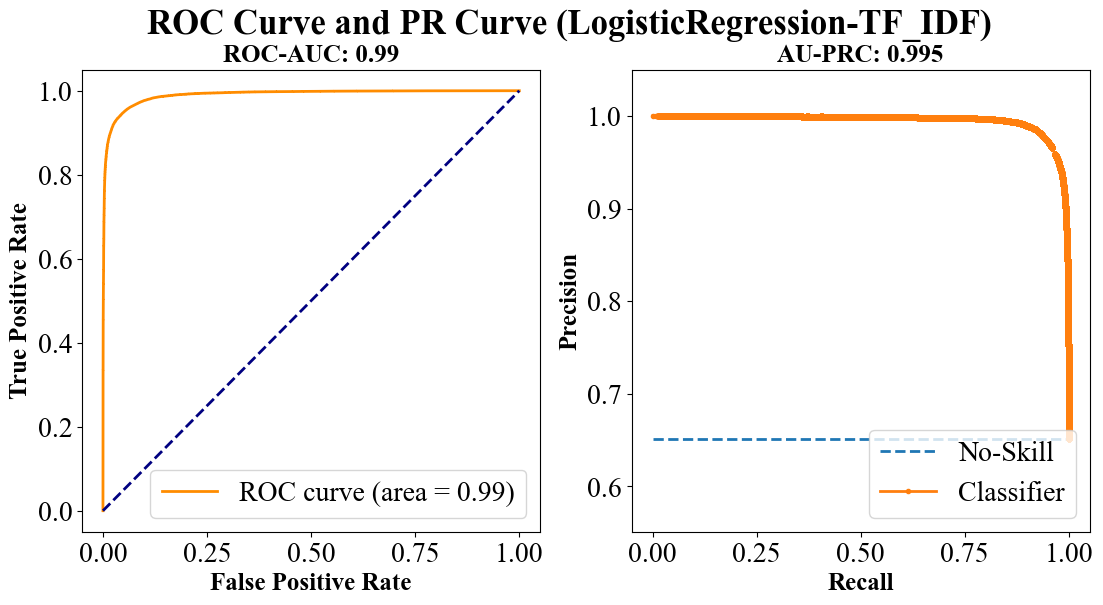

In [49]:
#====================================================================================================#
# TF-IDF Logistic Regression

estimator = LogisticRegression
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
LogReg_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                           ,
                    param_grid   =  param_grid                          ,
                    n_jobs       =  -1                                  , # Ensure all available processors are used.
                    cv           =  5                                   ,
                    scoring      =  'f1_micro'                          , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                            , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  5000                                ,
                    X_train      =  X_train_tfidf_selected              ,
                    y_train      =  y_train                             ,
                    X_test       =  X_test_tfidf_selected               ,
                    y_test       =  y_test                              ,
                    )


### &#10148; Bag of Words Logistic Regression

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: LogisticRegression, vectorizer: BoW.
Optimized Params found by Grid Search:  {'C': 100, 'solver': 'liblinear'}
accuracy_score  : 0.9513
precision_score : 0.9665
recall_score    : 0.9584
f1_score_score  : 0.9624
ROC_AUC         : 0.9482

Confusion Matrix
 [[28861  1907]
 [ 2389 55023]]


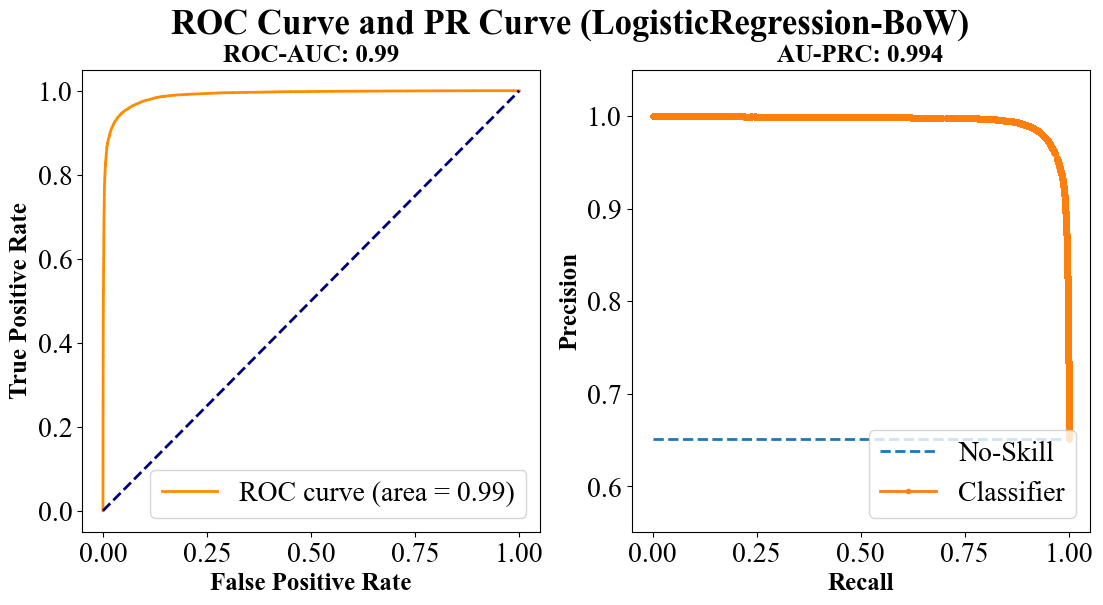

In [50]:
#====================================================================================================#
# Bag of Words Logistic Regression
lr_bow = LogisticRegression
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
LogReg_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  lr_bow                              ,
                    param_grid   =  param_grid                          ,
                    n_jobs       =  -1                                  , # Ensure all available processors are used.
                    cv           =  5                                   ,
                    scoring      =  'f1_micro'                          , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                    vectorizer   =  "BoW"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  5000                                ,
                    X_train      =  X_train_bow_selected                ,
                    y_train      =  y_train                             ,
                    X_test       =  X_test_bow_selected                 ,
                    y_test       =  y_test                              ,
                    )

### &#10148; TF-IDF Naive Bayes

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: MultinomialNB, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'alpha': 0.1}
accuracy_score  : 0.9072
precision_score : 0.8856
recall_score    : 0.9846
f1_score_score  : 0.9325
ROC_AUC         : 0.8736

Confusion Matrix
 [[23468  7300]
 [  887 56525]]


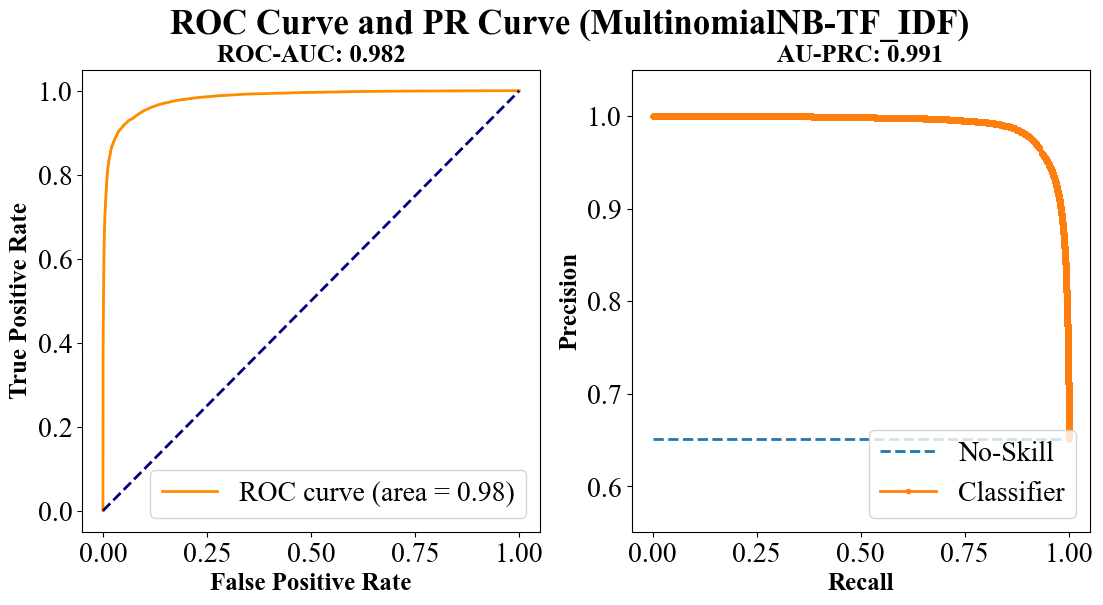

In [51]:
#====================================================================================================#
# TF-IDF Naive Bayes
estimator = MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
NaiveBayes_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                           , 
                    param_grid   =  param_grid                          , 
                    n_jobs       =  -1                                  , # Ensure all available processors are used.
                    cv           =  5                                   ,
                    scoring      =  'f1_micro'                          , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                            , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                , 
                    X_train      =  X_train_tfidf_selected              , 
                    y_train      =  y_train                             , 
                    X_test       =  X_test_tfidf_selected               , 
                    y_test       =  y_test                              , 
                    )



### &#10148; Bag of Words Naive Bayes

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: MultinomialNB, vectorizer: BoW.
Optimized Params found by Grid Search:  {'alpha': 0.1}
accuracy_score  : 0.9378
precision_score : 0.9475
recall_score    : 0.9576
f1_score_score  : 0.9525
ROC_AUC         : 0.9293

Confusion Matrix
 [[27719  3049]
 [ 2433 54979]]


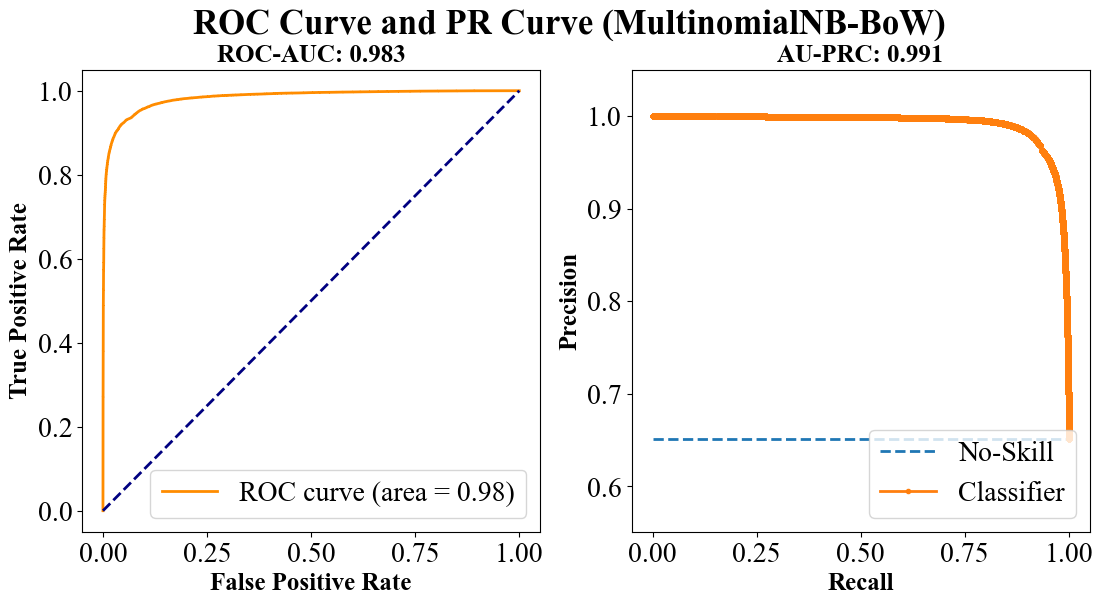

In [52]:
#====================================================================================================#
# Bag of Words Naive Bayes
estimator = MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
NaiveBayes_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                           , 
                    param_grid   =  param_grid                          , 
                    n_jobs       =  -1                                  , # Ensure all available processors are used.
                    cv           =  5                                   ,
                    scoring      =  'f1_micro'                          , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                    vectorizer   =  "BoW"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                , 
                    X_train      =  X_train_bow_selected                ,
                    y_train      =  y_train                             ,
                    X_test       =  X_test_bow_selected                 ,
                    y_test       =  y_test                              ,
                    )


### &#10148; TF-IDF Decision Tree

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: DecisionTreeClassifier, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10}
accuracy_score  : 0.8011
precision_score : 0.937
recall_score    : 0.7445
f1_score_score  : 0.8297
ROC_AUC         : 0.8256

Confusion Matrix
 [[27895  2873]
 [14668 42744]]


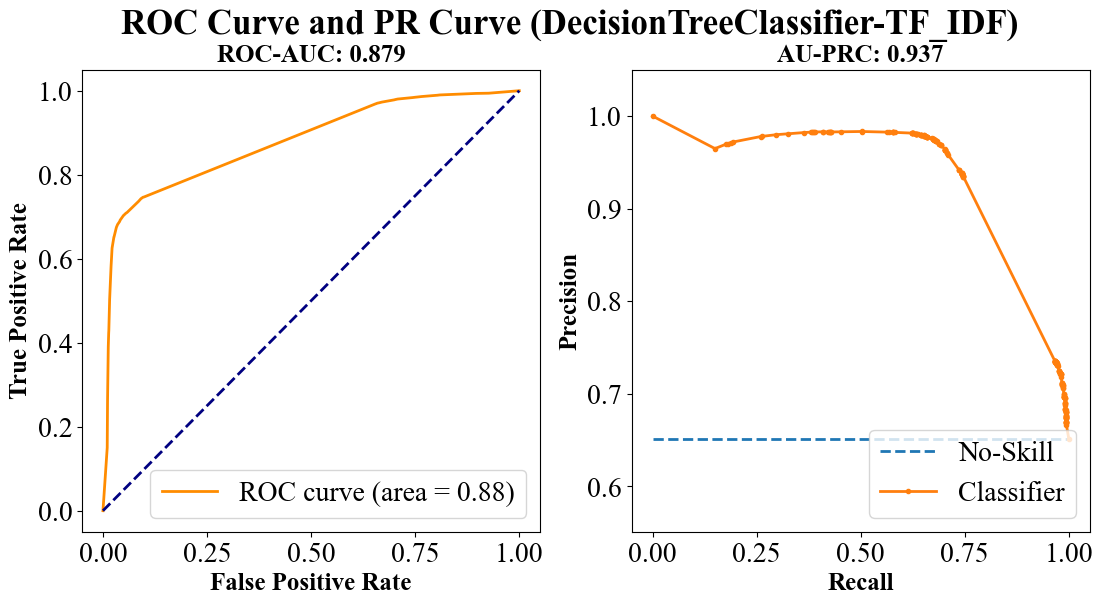

In [53]:
#====================================================================================================#
# TF-IDF Decision Tree
estimator = DecisionTreeClassifier
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
DT_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                           , 
                    param_grid   =  param_grid                          , 
                    n_jobs       =  -1                                  , # Ensure all available processors are used.
                    cv           =  5                                   ,
                    scoring      =  'f1_micro'                          , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                            , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                , 
                    X_train      =  X_train_tfidf_selected              , 
                    y_train      =  y_train                             , 
                    X_test       =  X_test_tfidf_selected               , 
                    y_test       =  y_test                              , 
                    )



### &#10148; Bag of Words Decision Tree

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: DecisionTreeClassifier, vectorizer: BoW.
Optimized Params found by Grid Search:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
accuracy_score  : 0.7872
precision_score : 0.779
recall_score    : 0.9397
f1_score_score  : 0.8519
ROC_AUC         : 0.7212

Confusion Matrix
 [[15467 15301]
 [ 3463 53949]]


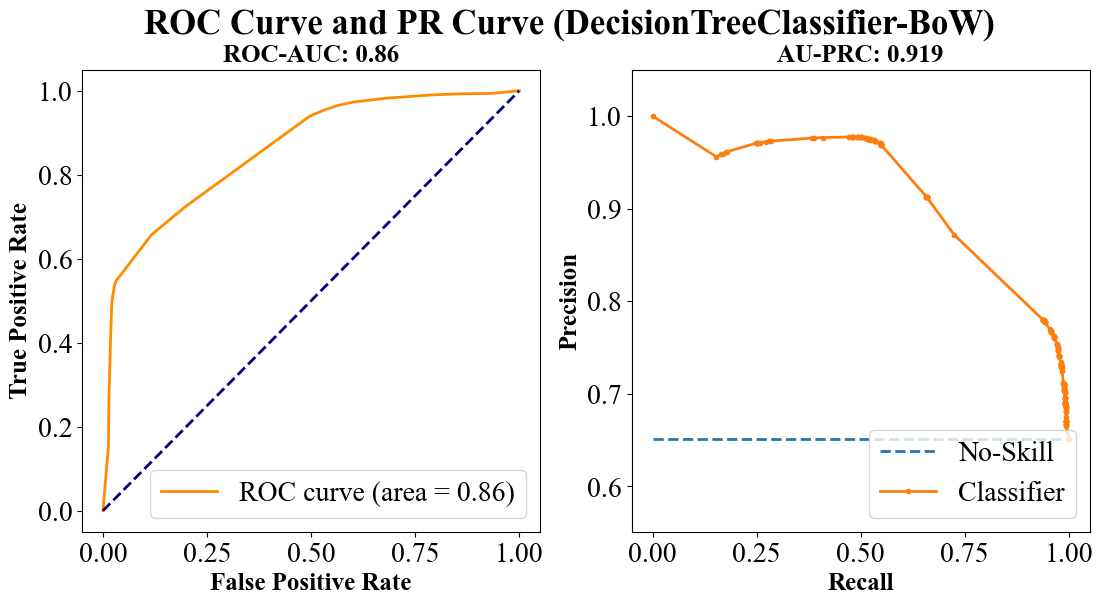

In [54]:
#====================================================================================================#
# Bag of Words Decision Tree
estimator = DecisionTreeClassifier
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
DT_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                           , 
                    param_grid   =  param_grid                          , 
                    n_jobs       =  -1                                  , # Ensure all available processors are used.
                    cv           =  5                                   ,
                    scoring      =  'f1_micro'                          , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p" , # Save grid search results. 
                    vectorizer   =  "BoW"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                , 
                    X_train      =  X_train_bow_selected                ,
                    y_train      =  y_train                             ,
                    X_test       =  X_test_bow_selected                 ,
                    y_test       =  y_test                              ,
                    )

### &#10148; TF-IDF XGBoost

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: XGBClassifier, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100}
accuracy_score  : 0.7552
precision_score : 0.8381
recall_score    : 0.7735
f1_score_score  : 0.8045
ROC_AUC         : 0.7473

Confusion Matrix
 [[22186  8582]
 [13002 44410]]


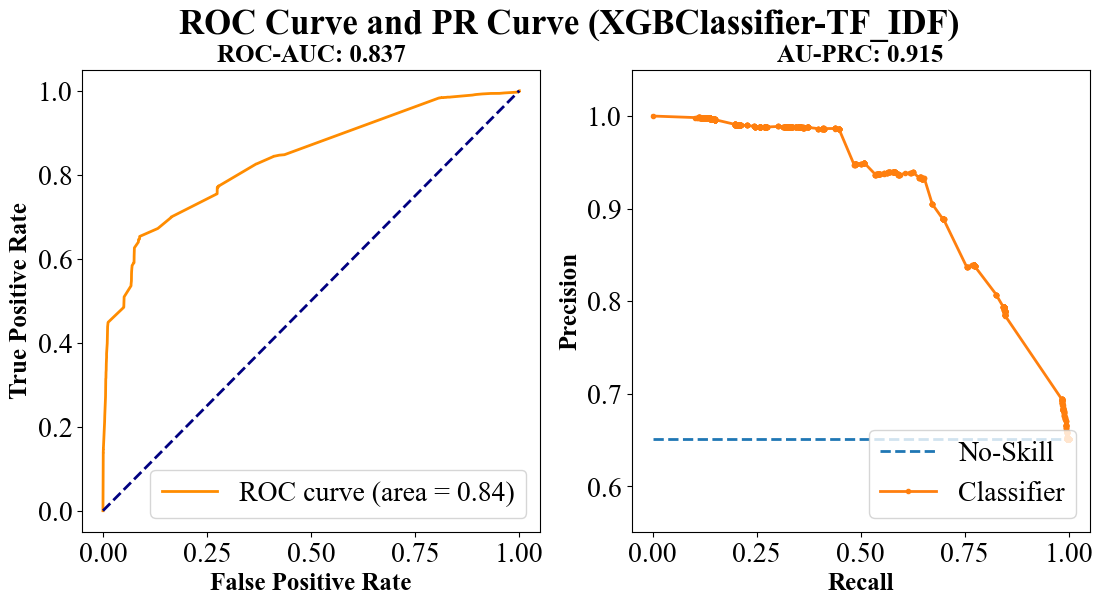

In [55]:
#====================================================================================================#
# TF-IDF XGBoost
estimator = XGBClassifier
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
XGBoost_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      ,
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p"    , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_tfidf_selected                 , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_tfidf_selected                  , 
                    y_test       =  y_test                                 , 
                    extra_params =  {"tree_method":'gpu_hist', "gpu_id":0} , 
                    )

### &#10148; Bag of Words XGBoost

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: XGBClassifier, vectorizer: BoW.
Optimized Params found by Grid Search:  {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}
accuracy_score  : 0.9512
precision_score : 0.9661
recall_score    : 0.9586
f1_score_score  : 0.9623
ROC_AUC         : 0.9479

Confusion Matrix
 [[28835  1933]
 [ 2374 55038]]


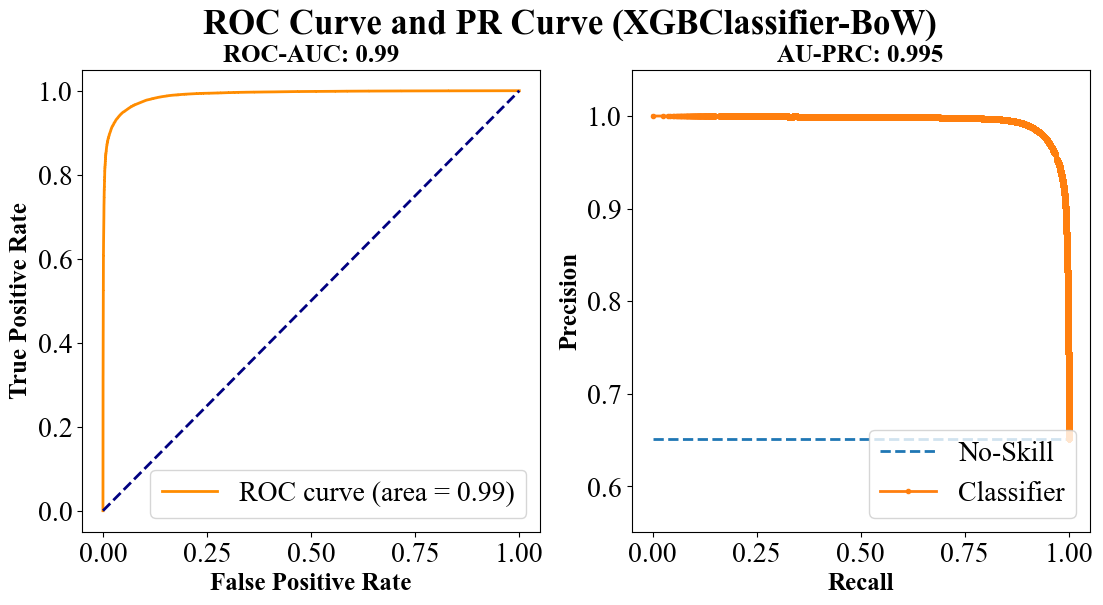

In [56]:
#====================================================================================================#
# Bag of Words XGBoost
estimator = XGBClassifier
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
XGBoost_BoW_Accuracy, GridSearch_results = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      , 
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p"    , # Save grid search results. 
                    vectorizer   =  "BoW"                                  , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_bow_selected                   , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_bow_selected                    , 
                    y_test       =  y_test                                 , 
                    extra_params =  {"tree_method":'gpu_hist', "gpu_id":0} , 
                    )

### &#10148; Support Vector Classifiers

In [57]:
from sklearn.svm import SVC
#====================================================================================================#
# TF-IDF SVC
estimator = SVC
param_grid = {'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
"""
SVC_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      ,
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p"    , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_tfidf_selected                 , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_tfidf_selected                  , 
                    y_test       =  y_test                                 , 
                    )
                    """
                    
#====================================================================================================#
# Bag of Words SVC
estimator = SVC
param_grid = {'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
"""
SVC_BoW_Accuracy, GridSearch_results = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      , 
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_Part_1_GridSearchSavings.p"    , # Save grid search results. 
                    vectorizer   =  "BoW"                                  , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_bow_selected                   , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_bow_selected                    , 
                    y_test       =  y_test                                 , 
                    )
                    """
SVC_TFIDF_Accuracy = 0.0
SVC_BoW_Accuracy   = 0.0




<br/>

## <font size="20"> &#8681; </font> MLP Classifier
- Apart from the 8 non-neural network models that we trained already, we tried to use MLP to learn the dataset.
- Define a general MLP Classifier
    - Using 3-layer FFNN as architecture.
    - Using CrossEntropyLoss as Criterion.
    - Output Heatmap that visualize the confusion matrix.

In [58]:
import torch
import torch.optim as optim

from torch import nn
from torch.utils import data

from torch.nn.utils.weight_norm import weight_norm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

#====================================================================================================#
# Define A MLP Classifier.
class MulticlassClassification(nn.Module):
    def __init__(self, 
                num_feature, 
                num_class,
                hid_1,
                hid_2,
                hid_3,
                drp_r,
                ):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, hid_1)
        self.layer_2 = nn.Linear(hid_1, hid_2)
        self.layer_3 = nn.Linear(hid_2, hid_3)
        self.layer_out = nn.Linear(hid_3, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drp_r)
        self.batchnorm1 = nn.BatchNorm1d(hid_1)
        self.batchnorm2 = nn.BatchNorm1d(hid_2)
        self.batchnorm3 = nn.BatchNorm1d(hid_3)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

#====================================================================================================#
# Define DataLoader and Dataset for the model.
class LoaderClass_LowRAM(Dataset):
    def __init__(self, X_data, y_data):
        super(LoaderClass_LowRAM, self).__init__()
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)
    def collate_fn(self, batch:List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
        X_data, y_data = zip(*batch)
        batch_size = len(X_data)

        return {'X_data': torch.from_numpy(np.array(X_data)), 'y_data': torch.tensor(np.array(list(y_data))) }


def generate_loader(X_tr, y_tr,
                    X_va, y_va,
                    X_ts, y_ts,
                    batch_size):
    X_y_tr = LoaderClass_LowRAM(list(X_tr), y_tr)
    X_y_va = LoaderClass_LowRAM(list(X_va), y_va)
    X_y_ts = LoaderClass_LowRAM(list(X_ts), y_ts)
    train_loader = data.DataLoader(X_y_tr, batch_size, True,  collate_fn = X_y_tr.collate_fn)
    valid_loader = data.DataLoader(X_y_va, batch_size, False, collate_fn = X_y_va.collate_fn)
    test_loader  = data.DataLoader(X_y_ts, batch_size, False, collate_fn = X_y_ts.collate_fn)
    return train_loader, valid_loader, test_loader 

#====================================================================================================#
# Define a trainer.
def General_MLP_Multi_Classifier( \
        X_train             =     None                                  ,
        y_train             =     None                                  ,
        X_test              =     None                                  ,
        y_test              =     None                                  ,
        epoch_num           =     100                                   ,
        batch_size          =     1000                                  ,
        learning_rate       =     1e-3                                  ,
        NUM_CLASSES         =     2                                     ,
        hid_1               =     1024                                  ,
        hid_2               =     1024                                  ,
        hid_3               =     1024                                  ,
        drp_r               =     0.5                                   ,
        fig_folder          =     Path("./Part1_Figures")               ,
        output_file_header  =     "MLP_Dataset_0_test_"                 ,
        save_model          =     Path("./Saving_MLP_Dataset_0_BoW.pt") ,
        ):
    #====================================================================================================#
    # Variables rename.  
    EPOCHS              =     epoch_num      
    BATCH_SIZE          =     batch_size     
    LEARNING_RATE       =     learning_rate  
    NUM_FEATURES        =     X_train.shape[1]

    #====================================================================================================#
    # Define a dict since classes read by pytorch shall be {0,1,...C-1} (Not Used here)
    def class_idx_conversion_dict(class_list, y_data): 
        class2idx = dict([])
        for idx, one_class in enumerate(class_list):
            class2idx[one_class] = idx
        idx2class = {v: k for k, v in class2idx.items()}
        y_data = [class2idx[one_class] for one_class in y_data]
        return class2idx, idx2class, y_data

    #====================================================================================================#
    # 
    def get_class_distribution(numerical_y_data, class_list = [0,1], ):
        count_dict = {class_x : 0 for class_x in class_list}
        for class_idx in numerical_y_data:
            count_dict[class_list[class_idx]] += 1
        return count_dict


    #====================================================================================================#
    # 
    #--------------------------------------------------#
    target_list = []
    for t in y_train:
        target_list.append(t)
        
    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]

    # print("target_list: ", target_list)

    class_count = [i for i in get_class_distribution(y_train).values()]
    class_weights = 1./torch.tensor(class_count, dtype = torch.float) 
    # print("class_weights: ", class_weights)

    ##====================================================================================================#
    train_loader, valid_loader, test_loader = \
        generate_loader(X_train, y_train,
                            X_test , y_test ,
                            X_test , y_test ,
                            batch_size)


    #====================================================================================================#
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #====================================================================================================#
    # 
    model = MulticlassClassification(NUM_FEATURES, 
                                    NUM_CLASSES,
                                    hid_1,
                                    hid_2,
                                    hid_3,
                                    drp_r,
                                    )
    model.to(device)
    criterion = nn.CrossEntropyLoss( weight = class_weights.to(device) )
    #criterion = nn.CrossEntropyLoss( )
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print("Model Architecture: ")
    print(model)


    #====================================================================================================#
    # 
    def multi_acc(y_pred, y_test):
        y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
        correct_pred = (y_pred_tags == y_test).float()
        acc = correct_pred.sum() / len(correct_pred)
        acc = torch.round(acc * 100)
        return acc

    #====================================================================================================#
    # Define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

    accuracy_stats = {'train': [], "valid": [] }
    loss_stats     = {'train': [], "valid": [] }

    #====================================================================================================#
    # 
    print("Begin training.")
    for epoch in range(1, EPOCHS+1):

        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for one_x_y_group in train_loader:
            input_vars = [one_x_y_group[one_var] for one_var in ["X_data",]]
            input_vars = input_vars[0].float().to(device)
            X_train_batch = input_vars
            y_train_batch = one_x_y_group["y_data"].long().to(device)
            #--------------------------------------------------#
            optimizer.zero_grad()
            #--------------------------------------------------#
            y_train_pred = model(X_train_batch)
            #--------------------------------------------------#
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
            #--------------------------------------------------#
            train_loss.backward()
            optimizer.step()
            #--------------------------------------------------#
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        


        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        # VALIDATION    
        with torch.no_grad():
            #--------------------------------------------------#
            valid_epoch_loss = 0
            valid_epoch_acc = 0
            #--------------------------------------------------#
            model.eval()
            for one_x_y_group in valid_loader:
                input_vars = [one_x_y_group[one_var] for one_var in ["X_data"]]
                input_vars = input_vars[0].float().to(device)
                X_valid_batch = input_vars
                y_valid_batch = one_x_y_group["y_data"].long().to(device)
                #--------------------------------------------------#
                y_valid_pred = model(X_valid_batch)
                #--------------------------------------------------#         
                valid_loss = criterion(y_valid_pred, y_valid_batch)
                valid_acc = multi_acc(y_valid_pred, y_valid_batch)
                #--------------------------------------------------#
                valid_epoch_loss += valid_loss.item()
                valid_epoch_acc  += valid_acc.item()
        #--------------------------------------------------#
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['valid'].append(valid_epoch_loss/len(valid_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['valid'].append(valid_epoch_acc/len(valid_loader))
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#



        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        print(f'   Epoch {epoch+0:03}: ' + \
              f' | Train Loss: {train_epoch_loss/len(train_loader)/100:.5f} ' + \
              f' | Valid Loss: {valid_epoch_loss/len(valid_loader)/100:.5f} ' + \
              f' | Train Acc: {train_epoch_acc/len(train_loader)/100:.3f} '   + \
              f' | Valid Acc: {valid_epoch_acc/len(valid_loader)/100:.3f} '       )
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#



    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # TESTING 
    y_pred_list = []
    score_list  = []
    with torch.no_grad():
        #--------------------------------------------------#
        # (1) Predict. 
        model.eval()
        for one_x_y_group in test_loader:
            input_vars   = [one_x_y_group[one_var] for one_var in ["X_data"]]
            X_test_batch = input_vars[0].float().to(device)
            y_test_pred = model(X_test_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())

            y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
            score_list .append(y_pred_softmax.cpu().detach().numpy())
        #--------------------------------------------------#
        y_pred_list = np.concatenate(y_pred_list)
        score_list  = np.concatenate(score_list )
        y_pred_proba = [np.exp(scores[1])/(np.exp(scores[0])+np.exp(scores[1])) for scores in score_list]
        y_pred = y_pred_list
        #--------------------------------------------------#
        # (2) Report Scores. 
        accuracy_score_test     =  np.round(accuracy_score (y_test, y_pred, ), 4)
        precision_score_test    =  np.round(precision_score(y_test, y_pred, ), 4)
        recall_score_test       =  np.round(recall_score   (y_test, y_pred, ), 4)
        f1_score_score_test     =  np.round(f1_score       (y_test, y_pred, ), 4)
        ROC_AUC_test            =  np.round(roc_auc_score  (y_test, y_pred, ), 4)
        print()
        print(f"accuracy_score  : {accuracy_score_test }")
        print(f"precision_score : {precision_score_test}")
        print(f"recall_score    : {recall_score_test   }")
        print(f"f1_score_score  : {f1_score_score_test }")
        print(f"ROC_AUC         : {ROC_AUC_test        }")
        
        #--------------------------------------------------#
        # (3) Report Confusion Matrix.
        #--------------------------------------------------#
        num_classes = 2
        font = {'family' : "Times New Roman"}
        plt.rc('font', **font)
        #--------------------------------------------------#
        cm = confusion_matrix(y_test, y_pred_list)
        cm = cm/len(y_pred_list) 
        confusion_matrix_df = pd.DataFrame(cm) #.rename(columns=idx2class, index=idx2class)

        fig = plt.figure(num=None, figsize=(12, 9.6), dpi = 200, facecolor='w', edgecolor='k')
        ax = sns.heatmap(confusion_matrix_df, 
                            annot      =  True             , 
                            fmt        =  ".3f"            , 
                            cmap       =  "magma"          , 
                            vmin       =  0.15             , 
                            vmax       =  0.30             , 
                            center     =  0.22             , 
                            cbar_kws   =  {"shrink": .82}  , 
                            linewidths =  0.1              , 
                            linecolor  =  'gray'           , 
                            annot_kws  =  {"fontsize": 30} , 
                            )

        ax.set_xlabel('Predictions', fontsize = 32)
        ax.set_ylabel('Actual Values', fontsize = 32)
        ax.set_title("Confusion Matrix - " \
                    + " \n (Prediction vs. Actual)", fontsize = 32)
        ax.xaxis.set_ticklabels([["neg", "pos"][i] for i in range(num_classes)], fontsize = 20)
        ax.yaxis.set_ticklabels([["neg", "pos"][i] for i in range(num_classes)], fontsize = 20)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        #plt.show()
        #--------------------------------------------------#
        fig.savefig(fig_folder / ("Confusion Matrix_" + output_file_header + "epoch_" + str(epoch) + "_") , dpi=1000 )
        #mpl.rcParams.update(mpl.rcParamsDefault)
        plt.close("all")

        plot_name = f"ROC Curve and PR Curve (MLP + " + output_file_header.replace("MLP_Dataset_0_test_", "") + ")"
        classification_plots(y_test, y_pred_proba, plot_name = plot_name)

    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#

    torch.save(model.state_dict(), save_model)
    return accuracy_score_test






<br/>

## <font size="20"> &#8681; </font> Reload Data and include more features (up to 10000) 
- This is just for 3-layer MLP-based Classifier, which is optional.
- (Requires ~50GB RAM since the function is not optimized)



In [59]:
#====================================================================================================#
# Teload Data.
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)

#====================================================================================================#
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

#====================================================================================================#
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# select 1000 best features by chi2
#====================================================================================================#
# TF-IDF
k = 10000 
selector = SelectKBest(chi2, k = k)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

#====================================================================================================#
# Bag of Words
selector = SelectKBest(chi2, k = k)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)
X_test_bow_selected = selector.transform(X_test_bow)



### &#10148; TF-IDF MLP Classifier

cuda:0
Model Architecture: 
MulticlassClassification(
  (layer_1): Linear(in_features=10000, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_out): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training.
   Epoch 001:  | Train Loss: 0.00124  | Valid Loss: 0.00947  | Train Acc: 0.948  | Valid Acc: 0.738 
   Epoch 002:  | Train Loss: 0.00055  | Valid Loss: 0.00097  | Train Acc: 0.980  | Valid Acc: 0.968 
   Epoch 003:  | Train Loss: 0.00040  | Valid Loss: 0.00120  | Train Acc: 0.984  | Valid Acc: 0.963 

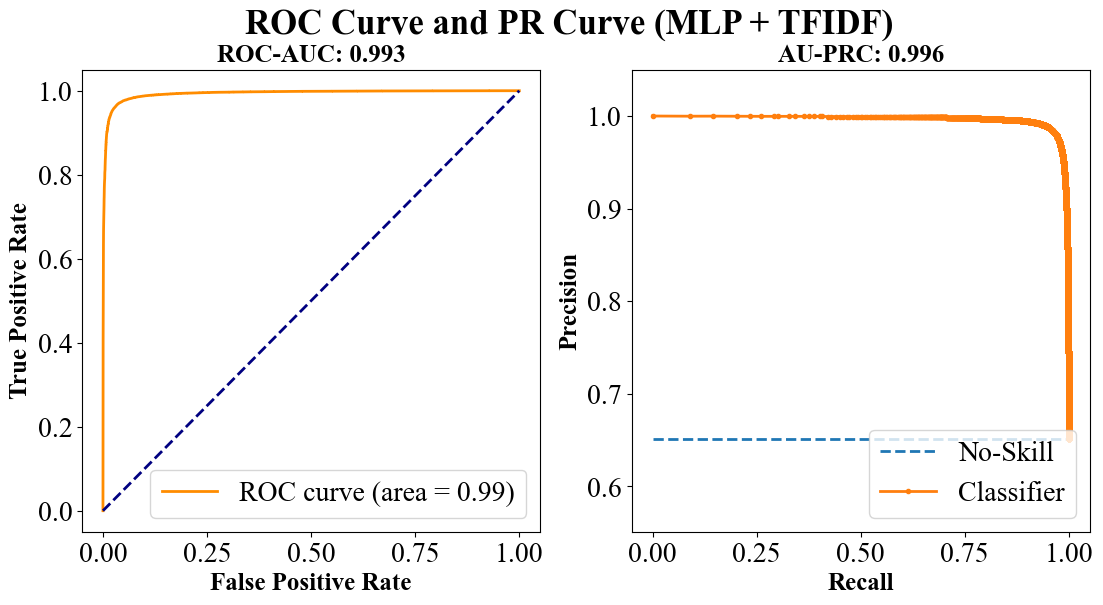

MLP_TFIDF_Accuracy:  0.9672
Trained model was saved here, ./Saving_Part_1_MLP_Dataset_0_TFIDF.pt . 


In [60]:
# TF-IDF MLP
#====================================================================================================#
# Data
X_train_MLP = X_train_tfidf_selected.toarray()
y_train_MLP = np.array(y_train)                
X_test_MLP  = X_test_tfidf_selected.toarray()
y_test_MLP  = np.array(y_test)                 
#====================================================================================================#
# Settings
EPOCHS              =     epoch_num                       = 10
BATCH_SIZE          =     batch_size                      = 5000
LEARNING_RATE       =     learning_rate                   = 1e-4
NUM_FEATURES        =     X_train_bow_selected.shape[1]
NUM_CLASSES         =     2
hid_1               =     1024
hid_2               =     1024
hid_3               =     1024
drp_r               =     0.1
fig_folder          =     Path("./Part1_Figures")
output_file_header  =     "MLP_Dataset_0_test_"

#====================================================================================================#
# Skip Training The model. (Requires ~60GB RAM)
MLP_TFIDF_Accuracy = \
    General_MLP_Multi_Classifier( \
        X_train             =     X_train_MLP                             ,
        y_train             =     y_train_MLP                             ,
        X_test              =     X_test_MLP                              ,
        y_test              =     y_test_MLP                              ,
        epoch_num           =     10                                      ,
        batch_size          =     5000                                    ,
        learning_rate       =     1e-3                                    ,
        NUM_CLASSES         =     2                                       ,
        hid_1               =     1024                                    ,
        hid_2               =     1024                                    ,
        hid_3               =     1024                                    ,
        drp_r               =     0.5                                     ,
        fig_folder          =     Path("./Part1_Figures")                 ,
        output_file_header  =     "MLP_Dataset_0_test_TFIDF"              ,
        save_model          =     Path("./Saving_Part_1_MLP_Dataset_0_TFIDF.pt") ,
        )
    
print("MLP_TFIDF_Accuracy: ", MLP_TFIDF_Accuracy)
print("Trained model was saved here, ./Saving_Part_1_MLP_Dataset_0_TFIDF.pt . ")

### &#10148; Bag of Words MLP Classifier

cuda:0
Model Architecture: 
MulticlassClassification(
  (layer_1): Linear(in_features=10000, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_out): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training.
   Epoch 001:  | Train Loss: 0.00107  | Valid Loss: 0.00088  | Train Acc: 0.958  | Valid Acc: 0.967 
   Epoch 002:  | Train Loss: 0.00058  | Valid Loss: 0.00093  | Train Acc: 0.978  | Valid Acc: 0.969 
   Epoch 003:  | Train Loss: 0.00041  | Valid Loss: 0.00103  | Train Acc: 0.985  | Valid Acc: 0.967 

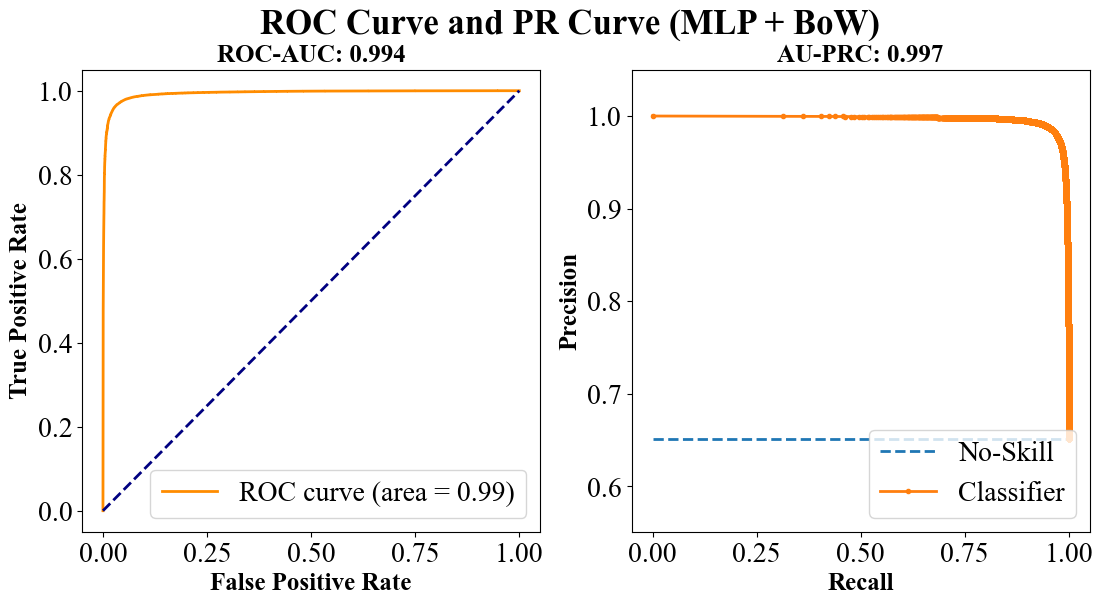

MLP_TFIDF_Accuracy:  0.9663
Trained model was saved here, ./Saving_Part_1_MLP_Dataset_0_BoW.pt . 


In [61]:
# BoW MLP
#====================================================================================================#
# Data
X_train_MLP = X_train_bow_selected.toarray()
y_train_MLP = np.array(y_train)                
X_test_MLP  = X_test_bow_selected.toarray()
y_test_MLP  = np.array(y_test)                 
#====================================================================================================#
# Settings
EPOCHS              =     epoch_num                       = 10
BATCH_SIZE          =     batch_size                      = 5000
LEARNING_RATE       =     learning_rate                   = 1e-4
NUM_FEATURES        =     X_train_bow_selected.shape[1]
NUM_CLASSES         =     2
hid_1               =     1024
hid_2               =     1024
hid_3               =     1024
drp_r               =     0.1
fig_folder          =     Path("./Part1_Figures")
output_file_header  =     "MLP_Dataset_0_test_"

#====================================================================================================#
MLP_BoW_Accuracy = \
General_MLP_Multi_Classifier( \
    X_train             =     X_train_MLP                           ,
    y_train             =     y_train_MLP                           ,
    X_test              =     X_test_MLP                            ,
    y_test              =     y_test_MLP                            ,
    epoch_num           =     10                                    ,
    batch_size          =     1000                                  ,
    learning_rate       =     1e-3                                  ,
    NUM_CLASSES         =     2                                     ,
    hid_1               =     1024                                  ,
    hid_2               =     1024                                  ,
    hid_3               =     1024                                  ,
    drp_r               =     0.5                                   ,
    fig_folder          =     Path("./Part1_Figures")               ,
    output_file_header  =     "MLP_Dataset_0_test_BoW"              ,
    save_model          =     Path("./Saving_Part_1_MLP_Dataset_0_BoW.pt") ,
    )


print("MLP_TFIDF_Accuracy: ", MLP_BoW_Accuracy)
print("Trained model was saved here, ./Saving_Part_1_MLP_Dataset_0_BoW.pt . ")



<br/>

## <font size="20"> &#8681; </font> Put Together All Results
- Report the best model
    - Hyperparameters
    - Model Performance

In [62]:
#====================================================================================================#
# 
print("Logistic Regression Accuracy     - TF-IDF: {:.4f}, BoW: {:.4f}".format(LogReg_TFIDF_Accuracy      , LogReg_BoW_Accuracy      ))
print("Naive Bayes Accuracy             - TF-IDF: {:.4f}, BoW: {:.4f}".format(NaiveBayes_TFIDF_Accuracy  , NaiveBayes_BoW_Accuracy  ))
print("Decision Tree Accuracy           - TF-IDF: {:.4f}, BoW: {:.4f}".format(DT_TFIDF_Accuracy          , DT_BoW_Accuracy          ))
print("XGBoost Accuracy                 - TF-IDF: {:.4f}, BoW: {:.4f}".format(XGBoost_TFIDF_Accuracy     , XGBoost_BoW_Accuracy     ))
print("MLP Accuracy                     - TF-IDF: {:.4f}, BoW: {:.4f}".format(MLP_TFIDF_Accuracy         , MLP_BoW_Accuracy         ))
#print("SupportVectorClassifier Accuracy - TF-IDF: {:.4f}, BoW: {:.4f}".format(SVC_TFIDF_Accuracy        , SVC_BoW_Accuracy         ))

optimized_params = GridSearch_results[("LogisticRegression", "TF_IDF")]

print("\nSummary: Among the Non-neural network approaches, LogisticRegression with TF_IDF has the best accuracy. ")
print(f"Grid Search has found best parameters for the model are, {optimized_params}")

Logistic Regression Accuracy     - TF-IDF: 0.9513, BoW: 0.9513
Naive Bayes Accuracy             - TF-IDF: 0.9072, BoW: 0.9378
Decision Tree Accuracy           - TF-IDF: 0.8011, BoW: 0.7872
XGBoost Accuracy                 - TF-IDF: 0.7552, BoW: 0.9512
MLP Accuracy                     - TF-IDF: 0.9672, BoW: 0.9663

Summary: Among the Non-neural network approaches, LogisticRegression with TF_IDF has the best accuracy. 
Grid Search has found best parameters for the model are, {'C': 100, 'solver': 'liblinear'}




<br/>

## <font size="20"> &#8681; </font> All Model Settings (Hyperparameters)

In [63]:
LogisticRegression(**optimized_params)

LogisticRegression(C=100, solver='liblinear')